In [1]:
import numpy as np
import pandas as pd
import pandas_profiling  as ppf

from sklearn.externals import joblib##模型的保存
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')  # 关闭警告模块

E:\soft\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
##数据的读取
train = pd.read_csv("DATA/sales_train_v2.csv")#训练集
test = pd.read_csv('DATA/test.csv')#测试集
shops = pd.read_csv('DATA/shops.csv')#商品集
items = pd.read_csv('DATA/items.csv')#
item_categories = pd.read_csv('DATA/item_categories.csv')

In [4]:
print('--------------------------------------------------------------------')
print (train.head())
print('--------------------------------------------------------------------')
print (items.head())
print('-------------------------------------------------------------------')
print (shops.head())
print('-------------------------------------------------------------------')
print (item_categories.head())
print('-------------------------------------------------------------------')
print (test.head())

# checking the shapes of these datasets
print("Shape of train:", train.shape)
print("Shape of test:", test.shape)
print("Shape of shops:", shops.shape)
print("Shape of items:", items.shape)
print("Shape of item_categories:", item_categories.shape)

--------------------------------------------------------------------
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
--------------------------------------------------------------------
                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0    

查看一下异常值 可视化,为什么出不来图

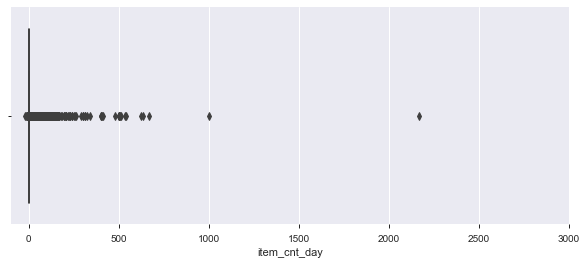

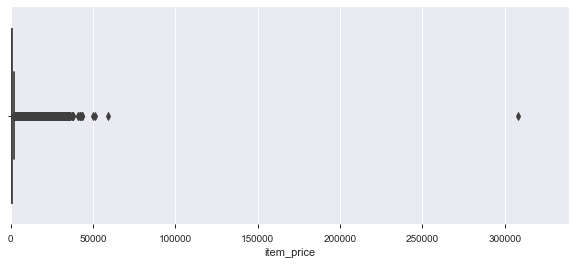

Wall time: 1.92 s


In [5]:
%%time
plt.figure(figsize=(10,4))#图的大小
plt.xlim(-100, 3000)#范围
sns.boxplot(x=train.item_cnt_day)#自变量
# plt.show()
plt.figure(figsize=(10,4))#图的大小
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)#最大值乘以1.1
sns.boxplot(x=train.item_price)#自变量
plt.show()

In [6]:
##先对每日销售的产品数量进行修改
train = train[train.item_cnt_day<1001]
train = train[train.item_cnt_day>0]
##再对产品的销售价格进行修改
train = train[train.item_price<250000]
train = train[train.item_price>1]

In [7]:
train.head()##这里只对两个变量进行了一个可视化，，，，

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0


# 数据重做--聚焦于item_cnt_month

对日期这列进行变换

In [8]:
%%time
train['date']= pd.to_datetime(train['date'], format='%d.%m.%Y')##官网进行查询

Wall time: 5.55 s


In [9]:
train["date"].head()##

0   2013-01-02
1   2013-01-03
3   2013-01-06
4   2013-01-15
5   2013-01-10
Name: date, dtype: datetime64[ns]

In [10]:
%%time
# 将数据转换为月度销售数据

# 制作仅包含月度销售数据的数据集
data = train.groupby([train['date'].apply(lambda x: x.strftime('%Y-%m')),'item_id','shop_id']).sum().reset_index()
##https://blog.csdn.net/Leonis_v/article/details/51832916--关于groupby的解释
##https://www.runoob.com/python/att-time-strftime.html--关于strftime的解释
# data.head()
# 指定我们要添加到数据的重要属性
data = data[['date','item_id','shop_id','item_cnt_day']]

# 最后，我们可以从数据集中选择重要的特定属性
data = data.pivot_table(index=['item_id','shop_id'], columns = 'date', values = 'item_cnt_day', fill_value = 0).reset_index()
##https://zhuanlan.zhihu.com/p/31952948--关于pivot_table的解释

print (data.shape)
print (data.head())#目的是把每一个月的放到一起

(423681, 36)
date  item_id  shop_id  2013-01  2013-02  2013-03  2013-04  2013-05  2013-06  \
0           0       54        0        0        0        0        0        0   
1           1       55        0        0        0        0        0        0   
2           2       54        0        0        0        0        0        0   
3           3       54        0        0        0        0        0        0   
4           4       54        0        0        0        0        0        0   

date  2013-07  2013-08  ...  2015-01  2015-02  2015-03  2015-04  2015-05  \
0           0        0  ...        0        0        0        0        0   
1           0        0  ...        0        0        0        0        0   
2           0        0  ...        0        0        0        0        0   
3           0        0  ...        0        0        0        0        0   
4           0        0  ...        0        0        0        0        0   

date  2015-06  2015-07  2015-08  2015-09  2015-10

In [11]:
test.head()#训练集和测试集变成一样就好了

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [12]:
##将数据进行组合
test = pd.merge(test, data, on = ['item_id', 'shop_id'], how = 'left')
##https://blog.csdn.net/weixin_37226516/article/details/64137043--merge的说明


# 将空值填充为0
test.fillna(0, inplace = True)

# 看一下这个数据集
test.head()

,ID,shop_id,item_id,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 创建实际的训练集

In [13]:
# 现在让我们创建实际的训练数据

x_train = test.drop(['2015-10', 'item_id', 'shop_id'], axis = 1)##和咱们提交格式有关
y_train = test['2015-10']

# 删除第一列，以便它可以预测未来的销售数据
x_test = test.drop(['2013-01', 'item_id', 'shop_id'], axis = 1)#保持和训练集一样的特征数

# 检查一下数据的维度看对不对
print("Shape of x_train :", x_train.shape)
print("Shape of x_test :", x_test.shape)
print("Shape of y_train :", y_train.shape)

Shape of x_train : (214200, 34)
Shape of x_test : (214200, 34)
Shape of y_train : (214200,)


## 数据的拆分

In [ ]:
#  #将数据拆分为训练和有效数据集

# from sklearn.model_selection import train_test_split

# x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.2, random_state = 10)

# # checking the shapes
# print("Shape of x_train :", x_train.shape)
# print("Shape of x_valid :", x_valid.shape)
# print("Shape of y_train :", y_train.shape)
# print("Shape of y_valid :", y_valid.shape)

## 模型的构建

In [14]:
%%time

# 用GradientBoostingRegressor进行预测
from sklearn.ensemble import GradientBoostingRegressor
GBR = GradientBoostingRegressor()
GBR.fit(x_train, y_train)
mode2 = GBR.predict(x_test).clip(0,20)##把预测之后的值限定在0到20之间
joblib.dump(GBR, 'GBR2.pkl')##模型的保存

Wall time: 17.2 s


['GBR2.pkl']

In [15]:
mode2=pd.DataFrame(mode2,columns=['item_cnt_month'])

In [16]:
mode2.head()

,item_cnt_month
0,0.502150
1,0.211889
2,0.766678
3,0.247797
4,0.211889


In [17]:
mode2.to_csv('submission.csv',index_label='ID')